# 1. 연구문제 : 주식시장 가격 예측
<div class="alert alert-block alert-success">
<font color="black" size="4e">Analysis Task</font>
<pre>
사람들은 주식을 거래를 할 때 정보를 얻기 위해 다양한 정보원에 의존하여 의사를 결정한다. 데이터 분석을 이용한다면 과거의 주가를 이용해 미래 주가를 예측할 수 있다. 
또한 향후 주가를 파악할 수 있는 시스템을 구축할 수 있다. 미래 주가를 예측할 수있도록 과거 주가와 데이터를 사용하여 분석한다면 더욱 합리적인 의사결정이 가능할 것이다.
이 과제에서는 예측 모델을 통해 주식의 종가(close price)를 예측한다.

※ 주식 종가 : 주식 거래일의 최종 거래 가격
※ 주식 시가(open price) : 주식 거래 해당일의 최초 거래 가격
</pre>
</div>

# 2. 데이터셋 수집

주가를 예측하기 위해 두가지의 데이터를 핵심으로 이용하여 모델을 구축한다.

1. 다우존스 산업지수(DJIA)
    - DIJA 지수는 특정 날짜의 주식 시장 움직임에 대한 전반적인 아이디어를 제공한다.
2. 뉴스기사
    - 뉴스 기사는 뉴스가 주가에 어떻게 영향을 미치는지를 알아내는데 도움이 된다.

## 2-1) DJIA 지수 가격 수집
- DJIA 지수 가격을 수집하기 위해 [야후파이낸스](https://finance.yahoo.com/quote/%5EDJI/history?period1=1266364800&period2=1581897600&interval=1d&filter=history&frequency=1d)를 사용한다. 
- 분석을 위한 데이터는 209년12월29일 부터 2019년12월31일 까지 10년 동안의 데이터를 활용한다.
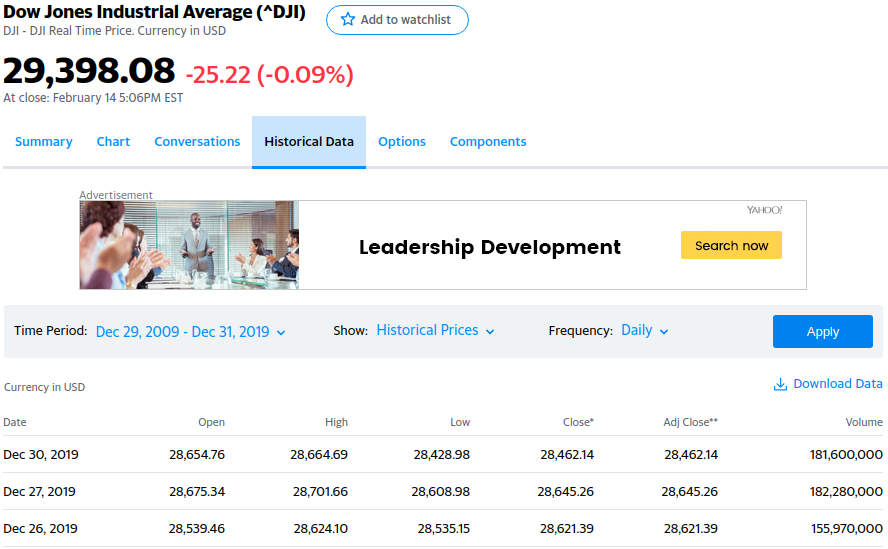

## 2-2) 뉴스 기사 수집
- 뉴스 기사를 수집해 뉴스가 DJIA 지수 값에 어떻게 영향을 미치는지에 대해 상관분석을 한다.
- 뉴스 기사에 대해 정서 분석(Sentiment Analysis)를 진행한다.
- 어떤 뉴스가 금융 시장에 부정적인 영향을 미친다면 주가가 하락할 것이고, 긍정적인 기사가 있다면 주가가 오를 가능성이 있다.

In [1]:
from newsapi.articles import Articles
import sys, json
import requests

In [2]:
key = 'tOSTQnWb2iu8vpWyPklg5KwjI9cgG8IJ'
params = {}
api = Articles(API_KEY = key)

In [3]:
# 예외처리를 위한 메서드
class APIKeyException(Exception):
    def __init__(self, message):
        self.message = message
        
class InvalidQueryException(Exception):
    def __init__(self, message):
        self.message = message

In [4]:
# API key를 확인하고 뉴스 기사 데이터를 가져올 수 있는 URL을 요청한다.
class ArchiveAPI(object):
    def __init__(self, key=None):
        self.key = key
        self.root = 'https://api.nytimes.com/svc/archive/v1/{}/{}.json?api-key={}'
        if not self.key:
            nyt_dev_page = 'http://developer.nytimes.com/docs/reference/keys'
            exception_str = 'Warning: API key required. Please visit {}'
            raise APIKeyException(exception_str.format(nyt_dev_page))
            
    def query(self, year=None, month=None, key=None):
        if not key:
            key = self.key
        if (year < 1882) or not (0 < month < 13) :
            exception_str = "Invalid query : See http://developer.nytimes.com/archive_api.json"
            raise InvalidQueryException(exception_str)
        url = self.root.format(year,month,key)
        print(url)
        r = requests.get(url)
        return r.json()

In [ ]:
# ArchiveAPI를 호출하고 2010년에서 2019년에 해당하는 연도를 전달하여 Json형식으로 저장한다.

years = [2010,2011,2012,2013,2014,
         2015,2016,2017,2018,2019]
months = [i + 1 for i in range(12)]
api = ArchiveAPI(key)

for year in years:
    for month in months:
        
        mydict = api.query(year, month)
        file_str = './data/nytimes' + str(year) + '-' + '{:02}'.format(month) + '.json'
        
        with open(file_str,'w') as fout:
            json.dump(mydict, fout)
        fout.close

# 3. 데이터셋 이해

## DJIA 데이터셋
- DJIA 데이터셋에는 7가지 변수가 있다.

1. Date : YYYY-MM-DD 형식의 거래 일자
2. Open : 특정일의 주식 시가
3. High : 특정 거래일에 대한 DJIA 지수의 고가(high price).
4. Low : 특정 거래일에 대한 DJIA 지수의 저가(low price).
5. Close : 거래일 끝나는 시점의 DJIA 지수의 가격, 주식 종가(closing price).
6. Adj close : 수정 종가(adjusted closing price)는 종가를 기준으로 주식 분할 및 신주 배당과 같은 요인을 고려해 조정한 가격.
    - 수정 종가는 DJIA 지수의 진정한 반영 지표이다. 예를 들어보면, 한 회사가 주당 5달러의 배당금을 제공하고 해당 회사의 종가가 100달러라면, 수정 종가는 95달러가 된다. 
    - 대부분의 경우는 종가와 수정 종가는 서로 같다.
7. Volume : 거래량(volume)값, 과거 특정 거래일에 거래소에서 거래되는 지수의 개수.

## 뉴욕타임즈 뉴스 기사 데이터셋
- 뉴욕타임즈 뉴스 기사 데이터셋에서는 모든 변수를 사용하지않고 몇가지 변수만 추출하여 사용한다.

1. type_of_material : 특정 콘텐츠가 블로그, 뉴스기사, 분석인지를 나타낸다.
2. headlines : 이 변수에는 두 개의 하위 데이터 특성이 있다. 
    - 주제(main) : 뉴스의 실제 헤드라인
    - 부제(kicker) : 기사의 요점
3. pud_date : 기사의 발행일자.
4. section_name : 뉴스 기사의 분야
5. news_desk : 뉴스 기사의 분야, section_name이 응답이 없을 때 이 변수를 사용한다.

# 4. 데이터 전처리 및 데이터분석

## 4-1) DJIA 데이터셋 준비
- 데이터셋에서 변수는 종가와 수정 종가만을 사용한다.
- 전일 종가와 시가는 거의 똑같기 때문에 종가만을 고려한다.
- 또한 DJIA 지수의 전반적인 추세에 관심을 두고 분석하는 것이기 때문에 종가와 수정종가 두가지를 고려한다.

In [6]:
import numpy as np
import pandas as pd
import json

In [27]:
# DJIA 데이터셋 로드
df = pd.read_csv("./data/DJIA2010_2020.csv")
df.set_index('Date', inplace = True, drop = True)
df = df[['Close','Adj Close']]
df.rename(columns={'Close':'close','Adj Close' : 'adj close'}, inplace = True)
df.head()

,close,adj close
Date,,
2009-12-29,10545.410156,10545.410156
2009-12-30,10548.509766,10548.509766
2009-12-31,10428.049805,10428.049805
2010-01-04,10583.959961,10583.959961
2010-01-05,10572.019531,10572.019531


## 4-2) DJIA 데이터셋 기본 분석

In [28]:
# 데이터프레임 복사
df1 = df

# idx는 전체기간의 범위를 담는다.
idx = pd.date_range('12-29-2009', '12-31-2019')

# 데이터프레임에서 빠져있는 날짜를 idx를 통해서 넣는다.
df1.index = pd.DatetimeIndex(df1.index)
df1 = df1.reindex(idx, fill_value=np.NaN) # NaN값으로 대체
df1.head()

,close,adj close
2009-12-29,10545.410156,10545.410156
2009-12-30,10548.509766,10548.509766
2009-12-31,10428.049805,10428.049805
2010-01-01,NaN,NaN
2010-01-02,NaN,NaN


In [29]:
# 결측치는 Pandas의 Interpolation(보간) 기능을 사용한다.
# Linear interpolation을 사용하여 결측값을 대체한다.
interpolated_df = df1.interpolate()
print(interpolated_df.count())
interpolated_df = interpolated_df[3:]

close        3655
adj close    3655
dtype: int64


In [30]:
# 총 3649개의 데이터
interpolated_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3652 entries, 2010-01-01 to 2019-12-31
Freq: D
Data columns (total 2 columns):
close        3652 non-null float64
adj close    3652 non-null float64
dtypes: float64(2)
memory usage: 85.6 KB


In [31]:
interpolated_df.isnull().sum()

close        0
adj close    0
dtype: int64

In [32]:
interpolated_df.head()

,close,adj close
2010-01-01,10467.027344,10467.027344
2010-01-02,10506.004883,10506.004883
2010-01-03,10544.982422,10544.982422
2010-01-04,10583.959961,10583.959961
2010-01-05,10572.019531,10572.019531


## 4-3) 뉴욕 타임즈 뉴스 데이터셋 준비
- 전체 뉴스기사 중에서 기사 분야를 선택하여 선별 매커니즘을 사용한다.
- 전처리는 다음 과정으로 진행한다.

    1. 발행 일자를 YYYY-MM-DD 형식으로 변환한다.
    2. 뉴스 기사를 분야에 맞게 분류한다.
    3. 필터를 구현하고 데이터셋을 병합한다.
    4. 병합된 데이터셋을 pickle 파일 형식으로 저장한다.

### 4-3-1) 발행 일자 변환

In [33]:
# json 파일에 있던 날짜 형식을 YYYY-MM-DD 형식으로 바꾼다.
date_format = ["%Y-%m-%dT%H:%M:%SZ", "%Y-%m-%dT%H:%M:%S+%f"]

def try_parsing_date(text):
    for fmt in date_format:
        try:
            return datetime.strptime(text, fmt).strftime("%Y-%m-%d")
        except ValueError:
            pass
    raise ValueError("no valid date format found")

In [34]:
print(years)
print(months)

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [35]:
dict_keys = ['pub_date', 'headline']
articles_dict = dict.fromkeys(dict_keys)

# type_of_material의 필터링 리스트 생성
type_of_material_list = ['blog', 'brief', 'news', 'editorial', 'op-ed', 'list','analysis']

# section_name 리스트
section_name_list = ['business', 'national', 'world', 'u.s.' , 'politics', 'opinion', 'tech', 'science',  'health']
news_desk_list = ['business', 'national', 'world', 'u.s.' , 'politics', 'opinion', 'tech', 'science',  'health', 
                  'foreign']

current_date = '2019-01-01'
from datetime import datetime
current_article_str = ''

### 4-3-2) 필터 특징 구현 및 데이터셋 병합
- 각 json 파일을 반복하여 앞서 정의한 뉴스 분야에 맞게 추출한다.
- 다음으로 DJIA 데이터셋과 뉴욕타임즈 뉴스기사 데이터셋을 병합한다.

In [36]:
## 데이터프레임에 기사 컬럼을 추가
interpolated_df["articles"] = ''
count_articles_filtered = 0
count_total_articles = 0
count_main_not_exist = 0
count_unicode_error = 0
count_attribute_error = 0
for year in years:
    for month in months:
        file_str = './data/nytimes/' + 'nytimes' + str(year) + '-' + '{:02}'.format(month) + '.json'
        with open(file_str) as data_file:
            NYTimes_data = json.load(data_file)
        count_total_articles = count_total_articles + len(NYTimes_data["response"]["docs"][:])
        for i in range(len(NYTimes_data["response"]["docs"][:])):
            try:
                if any(substring in NYTimes_data["response"]["docs"][:][i]['type_of_material'].lower() 
                       for substring in type_of_material_list):
                    if any(substring in NYTimes_data["response"]["docs"][:][i]['section_name'].lower() 
                           for substring in section_name_list):

                        count_articles_filtered += 1
                        articles_dict = { your_key: NYTimes_data["response"]["docs"][:][i][your_key] 
                                         for your_key in dict_keys }
                        # headline에서 main을 선택
                        articles_dict['headline'] = articles_dict['headline']['main'] 
                        
                        # lead_paragraph를 선택
                        date = try_parsing_date(articles_dict['pub_date'])
                        if date == current_date:
                            current_article_str = current_article_str + '. ' + articles_dict['headline']
                        else:
                            interpolated_df.set_value(current_date, 'articles', 
                                                      interpolated_df.loc[current_date,'articles'] 
                                                      + '. ' + current_article_str)
                            current_date = date
                            current_article_str = articles_dict['headline']
                        # 한 해의 마지막에 대한 조건
                        if (date == current_date) and (i == len(NYTimes_data["response"]["docs"][:]) - 1):
                            interpolated_df.set_value(date, 'articles', current_article_str)

             # section_name 또는 type_of_material이 없을 경우에 대한 예외처리
            except AttributeError:

                count_attribute_error += 1
                # 기사의 내용이 news_desk_list 매칭이되는데 section_name이 없는 경우
                try:
                    if any(substring in NYTimes_data["response"]["docs"][:][i]['news_desk'].lower() 
                           for substring in news_desk_list):

                            count_articles_filtered += 1

                            articles_dict = { your_key: NYTimes_data["response"]["docs"][:][i][your_key] 
                                             for your_key in dict_keys }
                            # headline에서 main을 선택
                            articles_dict['headline'] = articles_dict['headline']['main'] 
                            # lead_paragraph를 선택

                            date = try_parsing_date(articles_dict['pub_date'])

                            if date == current_date:
                                current_article_str = current_article_str + '. ' + articles_dict['headline']
                            else:
                                interpolated_df.set_value(current_date, 'articles', 
                                                          interpolated_df.loc[current_date, 'articles']
                                                          + '. ' + current_article_str)
                                current_date = date

                                current_article_str = articles_dict['headline']
                            # 한 해의 마지막에 대한 조건
                            if (date == current_date) and (i == len(NYTimes_data["response"]["docs"][:]) - 1):
                                interpolated_df.set_value(date, 'articles', current_article_str)

                except AttributeError:
                    pass
                pass
            except KeyError:
                #print('key error')
                count_main_not_exist += 1
                pass
            except TypeError:
                #print("type error")
                count_main_not_exist += 1
                pass



print("필터된 기사의 수 : ",count_articles_filtered)
print("전체 기사의 수 : ",count_total_articles)
print("Main이 없는 기사의 수 : ",count_main_not_exist)
print("Unicode 오류가 난 기사의 수 : ",count_unicode_error)

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


필터된 기사의 수 :  356400
전체 기사의 수 :  1054697
Main이 없는 기사의 수 :  64376
Unicode 오류가 난 기사의 수 :  0


In [37]:
# section_name이 없거나 news_desk가 없는 기사들을 전부 모은다.

for date, row in interpolated_df.T.iteritems():
    if len(interpolated_df.loc[date, 'articles']) <= 400:
        month = date.month
        year = date.year
        file_str = './data/nytimes/' + 'nytimes' + str(year) + '-' + '{:02}'.format(month) + '.json'
        with open(file_str) as data_file:
            NYTimes_data = json.load(data_file)
        count_total_articles = count_total_articles + len(NYTimes_data["response"]["docs"][:])
        interpolated_df.set_value(date.strftime('%Y-%m-%d'), 'articles', '')
        for i in range(len(NYTimes_data["response"]["docs"][:])):
            try:
                articles_dict = { your_key: NYTimes_data["response"]["docs"][:][i][your_key]
                                 for your_key in dict_keys }
                articles_dict['headline'] = articles_dict['headline']['main']
                pub_date = try_parsing_date(articles_dict['pub_date'])

                if date.strftime('%Y-%m-%d') == pub_date:
                    interpolated_df.set_value(pub_date, 'articles', interpolated_df.loc[pub_date, 'articles'] 
                                              + '. ' + articles_dict['headline'])
            except KeyError:
                #print('key error')
                count_main_not_exist += 1
                pass
            except TypeError:
                #print("type error")
                count_main_not_exist += 1
                pass

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [38]:
interpolated_df.head()

,close,adj close,articles
2010-01-01 00:00:00,10467.027344,10467.027344,. Time Warner and Fox Reach Deal for Cable Dis...
2010-01-02 00:00:00,10506.004883,10506.004883,. Even Better than Pepperoni Pizza.... Transit...
2010-01-03 00:00:00,10544.982422,10544.982422,. Media Equation: And a Tablet Will Lead Them ...
2010-01-04 00:00:00,10583.959961,10583.959961,". In Galleon Cases, Timing Could Be Everything..."
2010-01-05 00:00:00,10572.019531,10572.019531,. Rajaratnam Expected to Face Additional Charg...
